In [1]:
# Real life data

import logging
import threading
import itertools
import json
import os
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func

from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Train a 2-layered LSTM in Watson Machine Learning

 
Telemanom ([Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf) - 2018


Let's find out first what ML libraries are supported by WML.


### Basic Definitions

Forecast 24 data points from a sequence length of 200

In [2]:

n_predictions = 24
n_sequence_length = 100

logger = logging

### Load data

In [3]:
# load data
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

### Build features

In [27]:
# build features

def addDailyTimeFeatures(df):
    df['hour1'] = np.sin(df.index.hour / 24)
    df['day1'] = np.sin(df.index.dayofweek / 7)
    df['hour2'] = np.cos(df.index.hour / 24)
    df['day2'] = np.cos(df.index.dayofweek / 7)
    #df['day'] = df.index.dayofyear
    #df['week'] = df.index.weekofyear
    return df

def addConsumptionLagDay(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1dayago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Days(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2daysago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLagHour(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1hourago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Hours(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2hoursago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def fixBlueMonday(df):
    df_blue_monday = df[(df.index.weekday != 0) | (df.index.hour != 9)].\
                        resample('1H').interpolate()
    return df_blue_monday


#featureList = ['KW','TEMP_AIR','UMIDADE_REL']
featureList = ['KW','TEMP_AIR']
stdscal = StandardScaler()
np_input2 = stdscal.fit_transform(df_input[featureList])

df_input2 = pd.DataFrame(np_input2, columns=featureList, index=df_input.index)

df_input2 = fixBlueMonday(df_input2)
df_input2 = addConsumptionLagDay(df_input2)
df_input2 = addConsumptionLag2Days(df_input2)
df_input2 = addConsumptionLagHour(df_input2)
df_input2 = addConsumptionLag2Hours(df_input2)


df_input2 = addDailyTimeFeatures(df_input2)


In [26]:
df_input2.head(28)

,KW,TEMP_AIR,KW_1dayago,KW_2daysago,KW_1hourago,KW_2hoursago,hour,day
timestamp,,,,,,,,
2019-09-18 03:00:00,0.797056,0.498175,0.742610,0.041041,0.797056,0.807945,0.124675,0.281843
2019-09-18 04:00:00,0.807945,0.498175,0.633719,-0.189186,0.797056,0.797056,0.165896,0.281843
2019-09-18 05:00:00,0.709943,0.658531,0.611941,-0.419412,0.807945,0.797056,0.206830,0.281843
2019-09-18 06:00:00,0.775277,0.681439,0.699054,-0.649639,0.709943,0.807945,0.247404,0.281843
2019-09-18 07:00:00,0.742610,0.910519,0.601052,-0.879866,0.775277,0.709943,0.287549,0.281843
2019-09-18 08:00:00,1.025727,1.299955,0.797056,-0.662084,0.742610,0.775277,0.327195,0.281843
2019-09-18 09:00:00,1.199952,1.620668,0.829723,-0.651195,1.025727,0.742610,0.366273,0.281843
2019-09-18 10:00:00,1.287065,2.033012,0.993059,-0.640305,1.199952,1.025727,0.404715,0.281843
2019-09-18 11:00:00,1.406845,2.422448,1.123729,-0.672973,1.287065,1.199952,0.442454,0.281843


In [6]:
#
# get rid of everything but KW for testing 
#   undo everything we did to add features
#
#df_input2 = df_input[['KW', 'TEMP_AIR']]

### Build Training and Test data

In [28]:

def shape_data(arr, shuffle=False):
    data = []
    for i in range(len(arr) - n_sequence_length - n_predictions):
        data.append(arr[i:i + n_sequence_length + n_predictions])
        
    data = np.array(data)
    # leave that to Keras model.fit
    #if shuffle:
    #    np.random.shuffle(data)
    X = data[:, :-n_predictions, :]
    y = data[:, -n_predictions:, 0]      
    return X,y


X_train,y_train = shape_data(df_input2[0:7000].values, shuffle=True)
X_test, y_test = shape_data(df_input2[7000:].values, shuffle=False)

In [29]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((6876, 100, 10), (6876, 24), (1246, 100, 10), (1246, 24))

### Instantiate keras based LSTM model

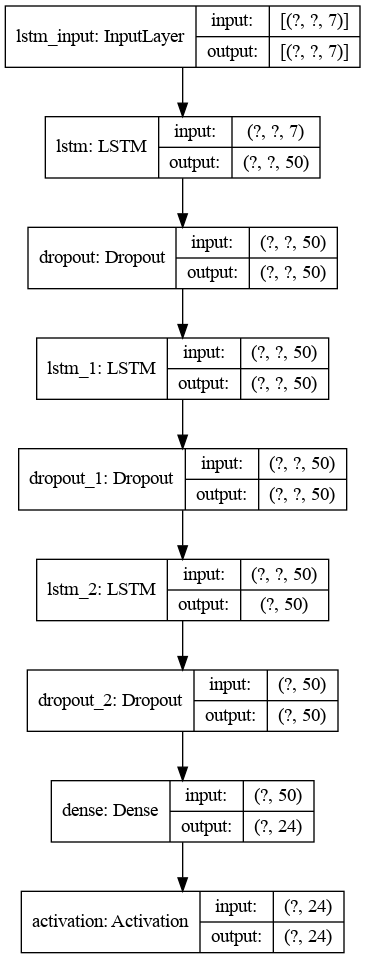

In [9]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import MeanSquaredError,MeanAbsoluteError
from keras.utils.vis_utils import plot_model


n_features = X_train.shape[2]


model_metric = MeanSquaredError()

model = Sequential()

model.add(LSTM(units=50, 
               input_shape=(None, n_features),
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               input_shape=(None, n_features),
               return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, 
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_predictions))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=[model_metric])


plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
cbs = [History(), EarlyStopping(monitor='val_loss', patience=3, min_delta=0.003, verbose=1)]
history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
                    shuffle=True, callbacks=cbs, verbose=True)


Epoch 1/27
86/86 [==============================] - 10s 116ms/step - loss: 0.6581 - mean_squared_error: 0.6581 - val_loss: 0.4400 - val_mean_squared_error: 0.4400
Epoch 2/27
86/86 [==============================] - 11s 124ms/step - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.3477 - val_mean_squared_error: 0.3477
Epoch 3/27
86/86 [==============================] - 11s 123ms/step - loss: 0.3816 - mean_squared_error: 0.3816 - val_loss: 0.4109 - val_mean_squared_error: 0.4109
Epoch 4/27
86/86 [==============================] - 11s 126ms/step - loss: 0.3366 - mean_squared_error: 0.3366 - val_loss: 0.5915 - val_mean_squared_error: 0.5915
Epoch 5/27
86/86 [==============================] - 11s 124ms/step - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.6538 - val_mean_squared_error: 0.6538
Epoch 00005: early stopping


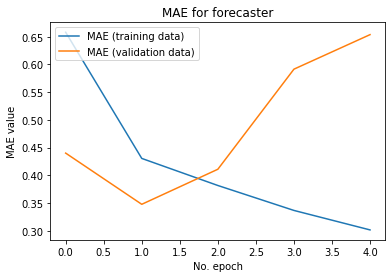

In [11]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for forecaster')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [12]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 3s 70ms/step - loss: 0.4712 - mean_squared_error: 0.4712


[0.4711650609970093, 0.4711650609970093]

In [13]:
#model.evaluate(X_train, y_train)
X_train.shape

(6876, 100, 7)

In [14]:
X_train[-24:0].shape

(0, 100, 7)

In [15]:
act = y_train[-2:-1].reshape(-1,1)
pred = model.predict(X_train[-2:-1]).reshape(-1,1)

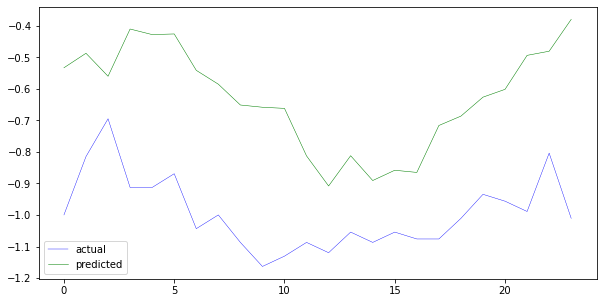

In [16]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()


In [68]:
import torch
import torch.autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split


def initialize_weights(model):
    print('initialize weights')
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight.data)
    elif type(model) in [nn.LSTM, nn.RNN, nn.GRU]:
        nn.init.xavier_uniform_(model.weight_hh_l0)
        nn.init.xavier_uniform_(model.weight_ih_l0)

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

class LSTM_2L(nn.Module):
    def __init__(self, n_features = 1, hidden_dims = [80,80], seq_length = 250,
                 batch_size = 64, n_predictions = 10, dropout = 0.1):
        super(LSTM_2L, self).__init__()
        print ('LSTM_2L', n_features, hidden_dims, seq_length, batch_size, n_predictions, dropout)

        self.n_features = n_features
        self.hidden_dim = hidden_dims[0]  # ignore second component for pytorch
        self.seq_length = seq_length
        self.num_layers = len(hidden_dims)
        self.batch_size = batch_size

        # using nn.LSTM so both layers end up with the same number of hidden dimensions
        self.lstm1 = nn.LSTM(
            input_size = self.n_features,
            hidden_size = self.hidden_dim,
            batch_first = True,
            dropout = dropout,
            num_layers = 2)

        self.linear = nn.Linear(self.hidden_dim, n_predictions)
        self.hidden = self.init_hidden_state()

    def init_hidden_state(self):
        #initialize hidden states (h_0, c_0)
        logger.debug('Hidden dimensions are: ' + str(self.num_layers) + ', ' +
                     str(self.batch_size) + ', ' + str(self.hidden_dim))

        return (
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)), #.to(self.device),
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)) #.to(self.device),
            )

    def forward(self, sequences, hidden = None):

        try:
            batch_size, seq_len, n_features = sequences.size()  # batch first
            logger.debug ('forward| Batch size: ' + str(batch_size) + ' Sequence length: ' + 
                          str(seq_len) + 'Output length:' + str(n_features))
        except Exception:
            logger.info ('forward issue in sequence: ' + str(sequences))

        #  for training
        if hidden is not None:
            self.hidden = hidden

        lstm1_out, hidden_out = self.lstm1(sequences, hidden)

        last_time_step = lstm1_out[:,-1,:]    # from (batch.size, input.size, hidden_dim.size)

        #lstm1_out_reshaped = lstm1_out.reshape(tuple((-1, *lstm1_out.shape[2:])))
        logger.debug ('Shapes ' + str(lstm1_out.shape) + ', ' + str(last_time_step.shape)
                      + ', ' + str(last_time_step.shape))

        #last_time_step = lstm1_out.view(-1, self.hidden_dims[0])

        #y_pred = self.linear(lstm1_out_reshaped)
        y_pred = self.linear(last_time_step)

        return y_pred, hidden_out


### Tensorboard support

Run `tensorboard --log=.\` in the notebooks directory to pick up training results

In [69]:
#instantiate summary writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# instantiate LSTM with input shape from training data
lstm = LSTM_2L(n_features = X_train.shape[2], hidden_dims = (80,80),
                 seq_length = 100, batch_size = 64,
                 n_predictions = 24, dropout = 0.1)

loss_function = nn.MSELoss()

# lr 0.0005 is a bit low, same with 0.0009, 0.0012, 0.0019
#    0.0029 looks better (test loss is lower, too)
#    0.0039 is too high (sharp spike in epoch 37)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0034)  

epochs = 45
train_hist = np.zeros(epochs)

# split out validation bucket
X_train_, X_validation_, y_train_, y_validation_ = train_test_split(X_train, y_train, train_size=0.8)

train_dataset=TensorDataset(torch.Tensor(X_train_),torch.Tensor(y_train_))
validation_dataset=TensorDataset(torch.Tensor(X_validation_),torch.Tensor(y_validation_))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=64, drop_last=True, shuffle=True)


lstm.train()

print("Beginning model training...")

validation_losses = []

hidden = lstm.init_hidden_state()
for t in range(epochs):
    train_losses_batch = []
    print ('Epoch ', t)

    i = 0
    for X_batch_train, y_batch_train in train_loader:
        #print ('Batch ', i)

        #self.model.zero_grad()

        i += 1

        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_train, hidden = lstm(X_batch_train, hidden=hidden)

        loss = loss_function(y_hat_train.float(), y_batch_train)
        train_loss_batch = loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        logger.debug('Batch ' + str(i-1) + ', Training loss ' + str(train_loss_batch))
        train_losses_batch.append(train_loss_batch)

    training_loss = np.mean(train_losses_batch)
    logger.debug ('After batch ' + str(i-1) + ', average training loss: ' + str(training_loss))
    
    writer.add_scalar('Loss/train', training_loss, t)
    train_losses_batch.append(training_loss)
    
    with torch.no_grad():
        val_losses_batch = []
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            lstm.eval()
            y_hat_val, _ = lstm(X_val_batch, hidden=hidden)
            val_loss_batch = loss_function(y_hat_val.float(), y_val_batch).item()
            logger.debug('Validating batch ' + str(j) + ', validation loss: ' + str(val_loss_batch))
            val_losses_batch.append(val_loss_batch)
        validation_loss = np.mean(val_losses_batch)
        print('After batch ' + str(i-1) + ', average validation loss: ' + str(validation_loss))
        
        writer.add_scalar('Loss/validation', validation_loss, t)
        validation_losses.append(validation_loss)

    print(f"[{t+1}] Training loss: {training_loss} \t Validation loss: {validation_loss} ")
    if training_loss < 0.02 and validation_loss < 0.02:
        break

print('Training complete...')

# return the model after switching off training mode
lstm.eval()


#history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
#                    shuffle=True, callbacks=cbs, verbose=True)

LSTM_2L 10 (80, 80) 100 64 24 0.1
Beginning model training...
Epoch  0
After batch 84, average validation loss: 0.38793562991278513
[1] Training loss: 0.528482494985356 	 Validation loss: 0.38793562991278513 
Epoch  1
After batch 84, average validation loss: 0.33515115011306035
[2] Training loss: 0.3398441800299813 	 Validation loss: 0.33515115011306035 
Epoch  2
After batch 84, average validation loss: 0.3162312642449424
[3] Training loss: 0.3000164931311327 	 Validation loss: 0.3162312642449424 
Epoch  3
After batch 84, average validation loss: 0.2719405988852183
[4] Training loss: 0.2800734283292995 	 Validation loss: 0.2719405988852183 
Epoch  4
After batch 84, average validation loss: 0.25463778773943585
[5] Training loss: 0.25003153190893285 	 Validation loss: 0.25463778773943585 
Epoch  5
After batch 84, average validation loss: 0.21877374748388925
[6] Training loss: 0.22282580908607033 	 Validation loss: 0.21877374748388925 
Epoch  6
After batch 84, average validation loss: 0.2

LSTM_2L(
  (lstm1): LSTM(10, 80, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=80, out_features=24, bias=True)
)

In [70]:
torch.save(lstm.state_dict(), './mylstmintorch')
# get all parameters with values
#  all_my_parameters = list(lstm.lstm1.named_parameters())

In [71]:
# validate on the test set
test_dataset=TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test))

test_loader = DataLoader(dataset=test_dataset, batch_size=64, drop_last=True)

i = 0
loss_test_batch = []
for X_batch_test, y_batch_test in test_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_test, hidden = lstm(X_batch_test, hidden=hidden)

        loss_test_batch.append(loss_function(y_hat_test.float(), y_batch_test).item())

    
loss_test = np.mean(loss_test_batch)
    
print('Loss Test ', loss_test)


fulltrain_dataset=TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
fulltrain_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True)

i = 0

loss_tr_batch = []
for X_batch_tr, y_batch_tr in fulltrain_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_tr, hidden = lstm(X_batch_tr, hidden=hidden)

        loss_tr_batch.append(loss_function(y_hat_tr.float(), y_batch_tr).item())
        prediction=y_hat_tr.float().numpy()
  
loss_tr = np.mean(loss_tr_batch)
    
print('Loss Train ', loss_tr)

    

Loss Test  0.39364978009344714
Loss Train  0.03463609759860179


In [72]:
prediction[-1]

array([-0.8395002 , -0.78541046, -0.774733  , -0.77409226, -0.80961925,
       -0.8505587 , -0.8513826 , -0.81975955, -0.77553904, -0.7984239 ,
       -0.7271275 , -0.67241806, -0.7251042 , -0.7545871 , -0.7072294 ,
       -0.64929605, -0.6648128 , -0.7086412 , -0.68326515, -0.63684744,
       -0.59898293, -0.618932  , -0.6487712 , -0.66742826], dtype=float32)

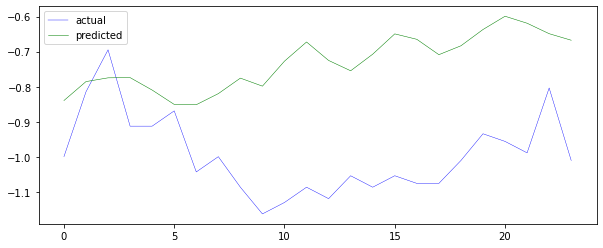

In [80]:
act = y_train[-2:-1].reshape(-1,1)
pred = prediction[-1]

#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()

#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>